In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


### 데이터 준비
#### Dataset - Auto MPG
- UCI 머신러닝 데이터 아카이브에서 다운로드
- pandas 를 이용해 데이터를 읽음.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

32768/30286 [================================] - 0s 9us/step


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 누락된 데이터
- 누락된 데이터 검사
- 누락된 row 삭제
- origin 은 수치형이 아니고 범주형이므로 one-hot 인코딩으로 변환

In [3]:
dataset.isna().sum()
dataset = dataset.dropna()

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 데이터셋 분할
- 훈련 세트와 테스트 세트로 분할
- 테스트 세트는 모델을 평가할때 사용됨

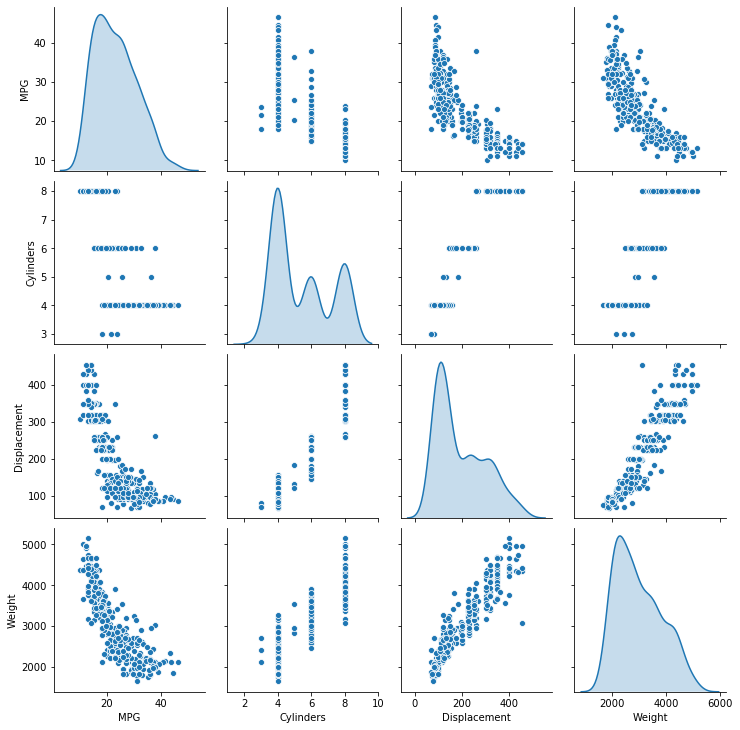

In [4]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#### 훈련 세트 데이터 분석
- 몇 개의 컬럼으로 산점도 행렬(joint distribution)을 구함
- 전반적인 통계도 확인

In [5]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Feature 와 Label 분리
- Feature 는 입력변수
- 레이블은 타겟 값 즉, 예측하고자 하는 변수로 사용하기 위해 분리
- 모델은 Label 을 예하기 위해 훈련시키는 대상임

In [6]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### 데이터 정규화
- 앞의 통계데이터를 분석해 feature 의 범위가 얼마나 다른지 확인
- 특성의 스케일과 범위가 다르 정규화가 권장됨.

In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

### 모델 구성
#### 모델 설계
- 두개의 완전연결(densely connected)은닉층을 sequential 모델을 생
- 출력층은 하나의 연속적인 값을 반환

In [8]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


array([[ 0.18836796],
       [ 0.32503903],
       [ 0.2217418 ],
       [ 0.69023013],
       [-0.1332689 ],
       [ 0.08678096],
       [-0.08185426],
       [-0.01525469],
       [ 0.09143007],
       [-0.15716779]], dtype=float32)

In [9]:
# 학습전 테스트셋 평가 결과
model = build_model()
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("학습전 테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 651.2547 - mae: 24.1788 - mse: 651.2547
학습전 테스트 세트의 평균 절대 오차: 24.18 MPG


#### 모델 훈련
- 샘플 데이터 10개의 배치로 확인결과 기대한 형태로 동작하는지 확인(앞에서)
- 1000 epoc 동안 훈련

In [10]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

# Data save
normed_train_data.to_csv("../data/mpg_trainset.csv")
normed_test_data.to_csv("../data/mpg_testset.csv")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [11]:
test_labels.to_csv("../data/mpg_testlabels.csv")

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.474801,0.979800,2.474801,10.021474,2.408328,10.021474,995
996,2.506591,0.991193,2.506591,10.145104,2.404832,10.145103,996
997,2.464807,0.994777,2.464808,9.908751,2.405276,9.908751,997
998,2.595513,0.991378,2.595513,10.327653,2.434165,10.327653,998
999,2.558547,0.997285,2.558547,10.028062,2.383992,10.028063,999


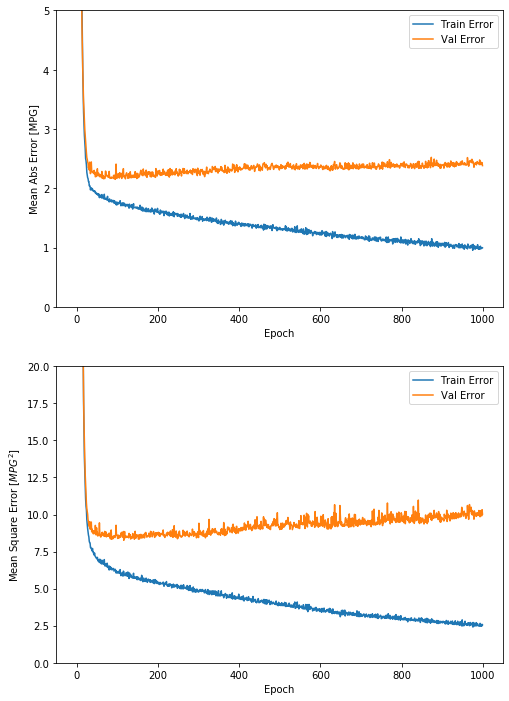

In [13]:
# 차트를 통해 확인
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


.......................................................

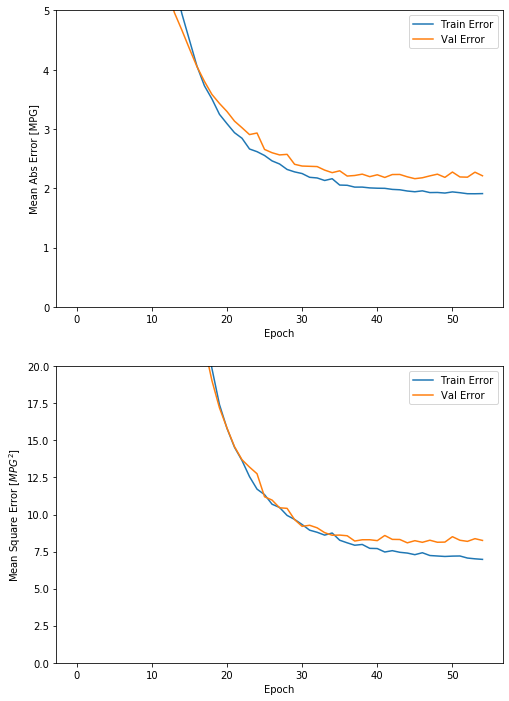

In [14]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [15]:
# Save the entire model to a HDF5 file
model.save('../models/mpg_model.h5')

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


78/78 - 0s - loss: 5.9122 - mae: 1.8713 - mse: 5.9122
테스트 세트의 평균 절대 오차:  1.87 MPG


#### 예측
- 테스트 데이터를 사용해 MPG 값을 예측

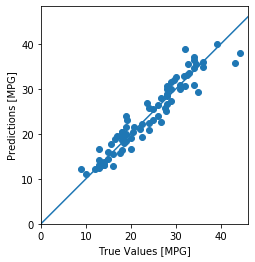

In [16]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

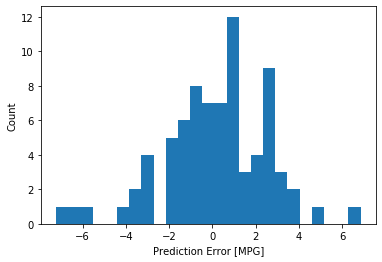

In [17]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")